## Conversation Gone Awry

In [1]:
import os

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.feature_selection import f_classif, SelectPercentile

from collections import defaultdict
from functools import partial
from multiprocessing import Pool

from convokit import download
from convokit.prompt_types import PromptTypeWrapper
from convokit import PolitenessStrategies
from convokit import Corpus, Speaker, Utterance
from convokit import Classifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Load dataset

In [3]:
# OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = ''
#AWRY_ROOT_DIR = download('conversations-gone-awry-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE TENNIS-CORPUS IS LOCATED
AWRY_ROOT_DIR = 'E:\EPFL_Courses\ADA\milestone-p3_data\conversations-gone-awry-corpus'
awry_corpus = Corpus(AWRY_ROOT_DIR)

#awry_corpus = Corpus(filename=download("conversations-gone-awry-corpus"))
awry_corpus.load_info('utterance',['parsed'])

awry_corpus = awry_corpus.filter_conversations_by(lambda convo: convo.meta['annotation_year'] == '2018')

In [4]:
awry_corpus.print_summary_stats()

Number of Speakers: 2010
Number of Utterances: 6363
Number of Conversations: 1168


In [5]:
conversations = awry_corpus.get_conversations_dataframe()
conversations

,vectors,meta.page_title,meta.page_id,meta.pair_id,meta.conversation_has_personal_attack,meta.verified,meta.pair_verified,meta.annotation_year,meta.split
id,,,,,,,,,
146743638.12652.12652,[],User talk:2005,1003212,143890867.11926.11926,False,True,True,2018,train
143890867.11926.11926,[],User talk:2005,1003212,146743638.12652.12652,True,True,True,2018,train
127296808.516.516,[],User talk:Billzilla,10051321,144643838.1236.1236,False,True,True,2018,train
144643838.1236.1236,[],User talk:Billzilla,10051321,127296808.516.516,True,True,True,2018,train
66813686.23567.23567,[],Talk:Niger uranium forgeries,1005730,68000691.25417.25417,False,True,True,2018,train
...,...,...,...,...,...,...,...,...,...
278765498.27104.27104,[],User talk:Grundle2600,10902498,275409490.16844.16844,True,True,True,2018,train
345472052.2707.2707,[],User talk:Aunt Entropy,15801810,236755381.13326.13326,False,True,True,2018,test
236755381.13326.13326,[],User talk:Aunt Entropy,15801810,345472052.2707.2707,True,True,True,2018,test


In [6]:
utterances = awry_corpus.get_utterances_dataframe()
utterances

,timestamp,text,speaker,reply_to,conversation_id,meta.is_section_header,meta.comment_has_personal_attack,meta.toxicity,meta.parsed
id,,,,,,,,,
146743638.12652.12652,1.1853e+09,== [WIKI_LINK: WP:COMMONNAME] ==\n,Sirex98,None,146743638.12652.12652,True,False,0,"[{'rt': 3, 'toks': [{'tok': '=', 'tag': 'NFP',..."
146743638.12667.12652,1.18528e+09,I notice that earier that moved wiki_link to ...,Sirex98,146743638.12652.12652,146743638.12652.12652,False,False,0.0781406,"[{'rt': 33, 'toks': [{'tok': 'I', 'tag': 'PRP'..."
146842219.12874.12874,1.18531e+09,"Chen was known in the poker world as ""William""...",2005,146743638.12667.12652,146743638.12652.12652,False,False,0.0317842,"[{'rt': 2, 'toks': [{'tok': 'Chen', 'tag': 'NN..."
146860774.13072.13072,1.18532e+09,I see what you saying I just read his pokersta...,Sirex98,146842696.12874.12874,146743638.12652.12652,False,False,0.030405,"[{'rt': 13, 'toks': [{'tok': 'I', 'tag': 'PRP'..."
143890867.11926.11926,1.18414e+09,==List of slang terms for poker hands==\n,WilyD,None,143890867.11926.11926,True,False,0,"[{'rt': 0, 'toks': [{'tok': '=', 'tag': 'NFP',..."
...,...,...,...,...,...,...,...,...,...
98071983.10061.9817,1.16781e+09,\n=== Mob rule by Franklin ===,FeloniousMonk,None,98071983.10061.9817,True,False,0,"[{'rt': 5, 'toks': [{'tok': '\n', 'tag': '', '..."
98071983.10077.9817,1.16779e+09,"According to our Founding Fathers, democracie...",FeloniousMonk,98071983.10061.9817,98071983.10061.9817,False,False,0,"[{'rt': 8, 'toks': [{'tok': ' ', 'tag': '', 'd..."
98073060.10318.10318,1.16779e+09,Look i went thru the procedure as stated in t...,Raspor,98071983.10061.9817,98071983.10061.9817,False,False,0,"[{'rt': 3, 'toks': [{'tok': ' ', 'tag': '', 'd..."


In [7]:
conv_attack = conversations[conversations['meta.conversation_has_personal_attack']==True]
conv_unattack = conversations[conversations['meta.conversation_has_personal_attack']==False]
print(conv_attack.shape)
print(conv_unattack.shape)

(584, 9)
(584, 9)


In [8]:
utt_attack = utterances[utterances['meta.comment_has_personal_attack']==True]
utt_unattack = utterances[utterances['meta.comment_has_personal_attack']==False]
print(utt_attack.shape)
print(utt_unattack.shape)

(584, 9)
(5779, 9)


In [9]:
spk_attack = list(set(list(utt_attack['speaker'])))
print(len(spk_attack))
spk_all = list(set(list(utterances['speaker'])))
print(len(spk_all))

513
2010


In [10]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Bar(
    name='attacked conversation',
    x=['conversations'], y=[584],
    marker_color="#5F5C33"),
    row=1, col=1)

fig.add_trace(go.Bar(
    name='unattacked conversation',
    x=['conversations'], y=[584],
    marker_color="#B3D66E"),
    row=1, col=1)


fig.add_trace(go.Bar(
    name='attacked utterance',
    x=['utterances'], y=[584],
    marker_color="#f8921d"),
    row=1, col=2)

fig.add_trace(go.Bar(
    name='unattacked utterance',
    x=['utterances'], y=[5779],
    marker_color="#FFFC99"),
    row=1, col=2)

fig.add_trace(go.Bar(
    name='attacker',
    x=['speakers'], y=[513],
    marker_color="#FFE882"),
    row=1, col=3)

fig.add_trace(go.Bar(
    name='victim',
    x=['speakers'], y=[1497],
    marker_color="#554840"),
    row=1, col=3)

fig.update_layout(barmode='group', title_text='Statistics of the dataset')

html = plot(fig, auto_open=False, output_type='div')
with open("E:/EPFL_Courses/ADA/linguistic_datastory/_includes/statistics.html", 'w') as file:
    file.write(html)

#### Get Utterence Word Clouds of the attack utterances

In [41]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [67]:
utts_attack = utterances[utterances['meta.comment_has_personal_attack']==True]

166672
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


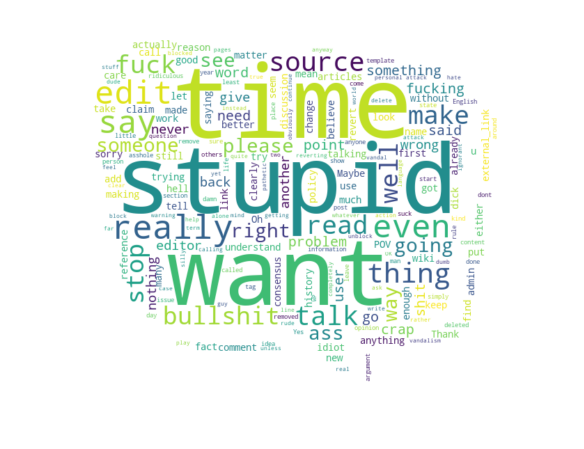

In [66]:
# Create and generate a word cloud image:

text = " ".join(text for text in utts_attack.text)
print(len(text))

mask = np.array(Image.open("bubble.png"))
mask = mask[:, :, 2]
mask[mask > 240] = 255


stopwords = set(STOPWORDS)
stopwords.update(["know", "think", "Wikipedia", "page", "one", "people", "article", "wiki_link", "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white", mask=mask).generate(text)

# Display the generated image:
fig=plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("wordcloud_attack.png")

1539031


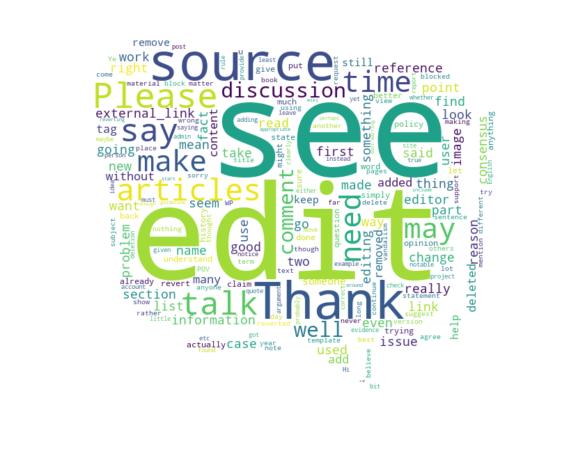

In [71]:
utts_attack = utterances[utterances['meta.comment_has_personal_attack']==False]

text = " ".join(text for text in utts_attack.text)
print(len(text))

mask = np.array(Image.open("bubble.png"))
mask = mask[:, :, 2]
mask[mask > 240] = 255


stopwords = set(STOPWORDS)
stopwords.update(["know", "think", "Wikipedia", "page", "one", "people", "article", "wiki_link", "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white", mask=mask).generate(text)

# Display the generated image:
fig=plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("wordcloud_nonattack.png")

#### Predict Politeness: Use wiki_corpus for training, then apply the classifier on awry_corpus to get the prediction score

In [13]:
# Downloading the wikipedia portion of annotated data
wiki_corpus = Corpus(download("wikipedia-politeness-corpus"))

Dataset already exists at C:\Users\Think\.convokit\downloads\wikipedia-politeness-corpus


In [14]:
wiki_corpus.print_summary_stats()

Number of Speakers: 1
Number of Utterances: 4353
Number of Conversations: 4353


In [15]:
ps = PolitenessStrategies()
awry_corpus = ps.transform(awry_corpus, markers=True)
wiki_corpus = ps.transform(wiki_corpus, markers=True)

In [16]:
test_ids = awry_corpus.get_utterance_ids()

In [17]:
train_corpus = Corpus(utterances=[utt for utt in wiki_corpus.iter_utterances()])
test_corpus = Corpus(utterances=[utt for utt in awry_corpus.iter_utterances()])
print("train size = {}, test size = {}".format(len(train_corpus.get_utterance_ids()),
                                               len(test_corpus.get_utterance_ids())))

train size = 4353, test size = 6363


In [18]:
clf = Classifier(obj_type="utterance", 
                        pred_feats=["politeness_strategies"], 
                        labeller=lambda utt: utt.meta['Binary'] == 1)
clf.fit(train_corpus)

Initialized default classification model (standard scaled logistic regression).


In [19]:
clf.evaluate_with_cv(corpus=train_corpus)

Using corpus objects...
Running a cross-validated evaluation...
Done.


array([0.78300804, 0.81171068, 0.78645235, 0.8137931 , 0.80689655])

In [20]:
test_pred = clf.transform(test_corpus)

In [21]:
pred_df = clf.summarize(test_pred)
pred_df

,prediction,pred_score
id,,
132662410.11977.11977,0,0.009742
410838569.61940.61940,0,0.019028
236161634.27143.27131,0,0.020131
444898053.3389.3389,0,0.020926
418695946.3459.3449,0,0.020926
...,...,...
268963140.3450.3450,1,0.990435
133500852.1477.1455,1,0.991651
433130034.579.562,1,0.993353


In [25]:
utt_with_attack = utterances[utterances['meta.comment_has_personal_attack']==True]
utt_attack_ids = utt_with_attack.index
print(len(utt_attack_ids))

584


In [26]:
test_utters_df = test_corpus.get_utterances_dataframe()

In [27]:
test_utters_df

,timestamp,text,speaker,reply_to,conversation_id,meta.is_section_header,meta.comment_has_personal_attack,meta.toxicity,meta.parsed,meta.politeness_strategies,meta.politeness_markers,meta.prediction,meta.pred_score
id,,,,,,,,,,,,,
146743638.12652.12652,1.1853e+09,== [WIKI_LINK: WP:COMMONNAME] ==\n,Sirex98,None,146743638.12652.12652,True,False,0,"[{'rt': 3, 'toks': [{'tok': '=', 'tag': 'NFP',...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",0,0.0833594
146743638.12667.12652,1.18528e+09,I notice that earier that moved wiki_link to ...,Sirex98,146743638.12652.12652,146743638.12652.12652,False,False,0.0781406,"[{'rt': 33, 'toks': [{'tok': 'i', 'tag': 'PRP'...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",0,0.225281
146842219.12874.12874,1.18531e+09,"Chen was known in the poker world as ""William""...",2005,146743638.12667.12652,146743638.12652.12652,False,False,0.0317842,"[{'rt': 2, 'toks': [{'tok': 'chen', 'tag': 'NN...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",0,0.266116
146860774.13072.13072,1.18532e+09,I see what you saying I just read his pokersta...,Sirex98,146842696.12874.12874,146743638.12652.12652,False,False,0.030405,"[{'rt': 13, 'toks': [{'tok': 'i', 'tag': 'PRP'...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",1,0.819434
143890867.11926.11926,1.18414e+09,==List of slang terms for poker hands==\n,WilyD,None,143890867.11926.11926,True,False,0,"[{'rt': 0, 'toks': [{'tok': '=', 'tag': 'NFP',...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",0,0.0833594
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98071983.10061.9817,1.16781e+09,\n=== Mob rule by Franklin ===,FeloniousMonk,None,98071983.10061.9817,True,False,0,"[{'rt': 5, 'toks': [{'tok': '\n', 'tag': '', '...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",0,0.0833594
98071983.10077.9817,1.16779e+09,"According to our Founding Fathers, democracie...",FeloniousMonk,98071983.10061.9817,98071983.10061.9817,False,False,0,"[{'rt': 8, 'toks': [{'tok': ' ', 'tag': '', 'd...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",0,0.125389
98073060.10318.10318,1.16779e+09,Look i went thru the procedure as stated in t...,Raspor,98071983.10061.9817,98071983.10061.9817,False,False,0,"[{'rt': 3, 'toks': [{'tok': ' ', 'tag': '', 'd...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",0,0.148742


In [28]:
avg_polite_ness = 0
for u_id in utt_attack_ids:
    pred_score = test_utters_df.loc[u_id]['meta.pred_score']
    avg_polite_ness += pred_score

print(avg_polite_ness / len(utt_attack_ids))

0.18280225979968698


In [29]:
utt_without_attack = utterances[utterances['meta.comment_has_personal_attack']==False]
utt_non_attack_ids = utt_without_attack.index
print(len(utt_non_attack_ids))

5779


In [30]:
avg_polite_ness = 0
for u_id in utt_non_attack_ids:
    pred_score = test_utters_df.loc[u_id]['meta.pred_score']
    avg_polite_ness += pred_score

print(avg_polite_ness / len(utt_non_attack_ids))

0.22239780898029585


#### Distribution of the number of utterance per conversation

In [31]:
# extract all utterances, the corresponding conversation_id and the personal attack sign
con_id = test_utters_df['conversation_id']
dfcon_id = pd.DataFrame(con_id)
dfcon_id['has_personal_attack']=test_utters_df['meta.comment_has_personal_attack']+0
dfcon_id.reset_index(inplace=True,drop=True)
dfcon_id

,conversation_id,has_personal_attack
0,146743638.12652.12652,0
1,146743638.12652.12652,0
2,146743638.12652.12652,0
3,146743638.12652.12652,0
4,143890867.11926.11926,0
...,...,...
6358,98071983.10061.9817,0
6359,98071983.10061.9817,0
6360,98071983.10061.9817,0
6361,98071983.10061.9817,0


In [32]:
# reserve the conversation_id and delete the duplicates
con_idname = pd.DataFrame(columns = ["conversation_id","num_uttr", 'has_attack'])
con_idname['conversation_id'] = dfcon_id['conversation_id']
con_idname=con_idname.drop_duplicates()
con_idname.reset_index(inplace=True,drop=True)
con_idname.loc[:,'num_uttr']=0
con_idname.loc[:,'has_attack']=0

# amout number of utterance in each conversation and reserve the attack sign
for num_con in range(len(con_idname)):
    for n_uid in range(len(dfcon_id)):
        if dfcon_id.loc[n_uid, 'conversation_id'] == con_idname.loc[num_con, 'conversation_id']:
            con_idname.loc[num_con,'num_uttr'] +=1
            if dfcon_id.loc[n_uid, 'has_personal_attack'] == 1:
                con_idname.loc[num_con,'has_attack'] = 1
con_idname

,conversation_id,num_uttr,has_attack
0,146743638.12652.12652,4,0
1,143890867.11926.11926,6,1
2,127296808.516.516,4,0
3,144643838.1236.1236,5,1
4,66813686.23567.23567,7,0
...,...,...,...
1163,278765498.27104.27104,5,1
1164,345472052.2707.2707,7,0
1165,236755381.13326.13326,5,1
1166,99357960.32952.32952,5,0


In [33]:
# delete the conversation IDs 
same_nu = pd.DataFrame(columns = ['num_uttr', 'same_num'])
same_nu['num_uttr'] = con_idname['num_uttr']
same_nu=same_nu.drop_duplicates()
same_nu.loc[:,'same_num']=0
same_nu.reset_index(inplace=True,drop=True)
same_nu.sort_values(by='num_uttr')

# compute the conversation number which have the same utterance number
for nu in range(len(same_nu)):
    for num_con in range(len(con_idname)):
        if same_nu.loc[nu, 'num_uttr'] == con_idname.loc[num_con, 'num_uttr']:
            same_nu.loc[nu,'same_num'] +=1 
same_nu

,num_uttr,same_num
0,4,387
1,6,171
2,5,322
3,7,102
4,9,28
5,3,58
6,16,3
7,8,44
8,10,18
9,11,10


In [34]:
# select the conversation that has attacked action and show the corresponding utterance number
attcon_id = con_idname.copy()
for n_con in range(len(con_idname)):
    if con_idname.loc[n_con, 'has_attack'] == 0:
        attcon_id = attcon_id.drop([n_con])
attcon_id = attcon_id.drop(['has_attack'], axis=1)
attcon_id.reset_index(inplace=True,drop=True)
attcon_id

,conversation_id,num_uttr
0,143890867.11926.11926,6
1,144643838.1236.1236,5
2,68000691.25417.25417,5
3,14969685.9097.9097,4
4,156725805.9367.0,6
...,...,...
579,175543533.9096.9096,5
580,198258127.2914.2914,5
581,278765498.27104.27104,5
582,236755381.13326.13326,5


In [36]:
# delete the conversation IDs 
attsame_nu = pd.DataFrame(columns = ['num_uttr', 'attsame_num'])
attsame_nu['num_uttr'] = attcon_id['num_uttr']
attsame_nu=attsame_nu.drop_duplicates()
attsame_nu.loc[:,'attsame_num']=0
attsame_nu.reset_index(inplace=True,drop=True)
attsame_nu.sort_values(by='num_uttr')

# compute the conversation number which have the same utterance number (in attacked conversation)
for nu in range(len(attsame_nu)):
    for num_con in range(len(attcon_id)):
        if attsame_nu.loc[nu, 'num_uttr'] == attcon_id.loc[num_con, 'num_uttr']:
            attsame_nu.loc[nu,'attsame_num'] +=1 
attsame_nu

,num_uttr,attsame_num
0,6,110
1,5,185
2,4,126
3,9,15
4,7,63
5,3,28
6,10,10
7,8,27
8,11,6
9,13,3


In [37]:
# merge the data of all conversation contain same utterance number
# and the data of attacked conversation number contain same utterance number
mer_same = pd.merge(same_nu, attsame_nu, how='left')
mer_same = mer_same.fillna(0)
mer_same['unatt_num'] = mer_same['same_num']-mer_same['attsame_num']
mer_same

,num_uttr,same_num,attsame_num,unatt_num
0,4,387,126.0,261.0
1,6,171,110.0,61.0
2,5,322,185.0,137.0
3,7,102,63.0,39.0
4,9,28,15.0,13.0
5,3,58,28.0,30.0
6,16,3,1.0,2.0
7,8,44,27.0,17.0
8,10,18,10.0,8.0
9,11,10,6.0,4.0


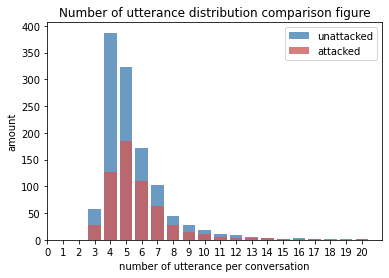

In [38]:
# plot the distribution comparison figure
plt.bar(x=mer_same['num_uttr'], height=mer_same['same_num'], label='unattacked', color='steelblue', alpha=0.8)
plt.bar(x=mer_same['num_uttr'], height=mer_same['attsame_num'], label='attacked', color='indianred', alpha=0.8)

plt.title("Number of utterance distribution comparison figure")
plt.xlabel('number of utterance per conversation')
plt.ylabel('amount')
plt.xticks(np.arange(0,21,1))

plt.legend()
plt.show()

In [39]:
##### Draw Plotly figure

fig = go.Figure()
fig.add_trace(go.Bar(
    x=mer_same['num_uttr'],
    y=mer_same['attsame_num'],
    name='attacked', # name used in legend and hover labels
    marker_color='#FFE882',
    opacity=0.75
))

fig.add_trace(go.Bar(
    x=mer_same['num_uttr'],
    y=mer_same['unatt_num'],
    name='unattacked', # name used in legend and hover labels
    marker_color='#B3D66E',
    opacity=0.75
))
    
fig.update_layout(
    title_text='Distribution of the number of utterances for attacked and unattacked conversations', # title of plot
    xaxis_title_text='Number of utterances per conversation', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates,
    barmode='stack'
)

html = plot(fig, auto_open=False, output_type='div')
with open("E:/EPFL_Courses/ADA/linguistic_datastory/_includes/conv_utt_types_dist.html", 'w') as file:
    file.write(html)

### V 1 Politeness Imbalance and Visualization

In [40]:
# first, we need to directly map comment IDs to their conversations. We'll build a DataFrame to do this
comment_ids = []
convo_ids = []
timestamps = []
page_ids = []
for conversation in awry_corpus.iter_conversations():
    for comment in conversation.iter_utterances():
        # section headers are included in the dataset for completeness, but for prediction we need to ignore
        # them as they are not utterances
        if not comment.meta["is_section_header"]:
            comment_ids.append(comment.id)
            convo_ids.append(comment.root)
            timestamps.append(comment.timestamp)
            page_ids.append(conversation.meta["page_id"])
comment_df = pd.DataFrame({"conversation_id": convo_ids, "timestamp": timestamps, "page_id": page_ids}, index=comment_ids)
# we'll do our construction using awry conversation ID's as the reference key
awry_convo_ids = set()
# these dicts will then all be keyed by awry ID
good_convo_map = {}
page_id_map = {}
for conversation in awry_corpus.iter_conversations():
    if conversation.meta["conversation_has_personal_attack"] and conversation.id not in awry_convo_ids:
        awry_convo_ids.add(conversation.id)
        good_convo_map[conversation.id] = conversation.meta["pair_id"]
        page_id_map[conversation.id] = conversation.meta["page_id"]
awry_convo_ids = list(awry_convo_ids)
pairs_df = pd.DataFrame({"bad_conversation_id": awry_convo_ids,
                         "conversation_id": [good_convo_map[cid] for cid in awry_convo_ids],
                         "page_id": [page_id_map[cid] for cid in awry_convo_ids]})


In [41]:
conversation

Conversation({'obj_type': 'conversation', 'meta': {'page_title': 'User talk:Raspor', 'page_id': 8071956, 'pair_id': '99357960.32952.32952', 'conversation_has_personal_attack': True, 'verified': True, 'pair_verified': True, 'annotation_year': '2018', 'split': 'test'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x000001D27465E970>, 'id': '98071983.10061.9817'})

In [42]:
def set_attack(x):
    indicator=[]
    if x==True:
        indicator = True
    elif x==False:
        indicator = False
    return indicator

def set_in_bad_convo(x,pairs_df):
    indicator=[]
    if x in pairs_df['bad_conversation_id'].tolist():
        indicator=True
    elif x in pairs_df['conversation_id'].tolist():
        indicator=False
    return indicator

test_utters_df['attack'] = test_utters_df['meta.comment_has_personal_attack'].apply(lambda x: set_attack(x))
test_utters_df['in_bad_convo'] = test_utters_df['conversation_id'].apply(lambda x: set_in_bad_convo(x,pairs_df))

In [43]:
# Group by 'conversation_id', 'speakier' and 'in_bad_convo' then get average predicted score
grouped = test_utters_df['meta.pred_score'].astype(float).groupby([test_utters_df['conversation_id'],test_utters_df['speaker'],test_utters_df['in_bad_convo'],test_utters_df['attack']])
means = pd.DataFrame(grouped.mean()).unstack()

In [44]:
means

meta.pred_score          
attack                                                      False     True 
conversation_id      speaker         in_bad_convo                          
100009118.8296.8296  Hiding          True                0.737203       NaN
                     Hipocrite       True                0.212301  0.152363
100082597.1198.1198  66.99.2.114     False               0.134273       NaN
                     MKil            False               0.120173       NaN
                     Wompa99         False               0.169016       NaN
...                                                           ...       ...
99357960.32952.32952 Raspor          False               0.077511       NaN
99560738.4755.4755   Captain scarlet True                0.164587       NaN
                     Lewisskinner    True                0.142842  0.687036
99634556.9406.9406   Matthew         False               0.128281       NaN
                     Otto4711        False               0.059012       NaN

[2955 rows x 2 columns]

In [45]:
def assign_attacker(x):
    indicator = []
    #print(x)
    if x==x:
        indicator=True
    else:
        indicator=False
    return indicator
means['is_attacker'] = means['meta.pred_score'][True].apply(lambda x: assign_attacker(x))

In [46]:
means['noattack_politeness_score'] = means['meta.pred_score'][False].apply(lambda x: x)

In [47]:
means

meta.pred_score            \
attack                                                      False      True   
conversation_id      speaker         in_bad_convo                             
100009118.8296.8296  Hiding          True                0.737203       NaN   
                     Hipocrite       True                0.212301  0.152363   
100082597.1198.1198  66.99.2.114     False               0.134273       NaN   
                     MKil            False               0.120173       NaN   
                     Wompa99         False               0.169016       NaN   
...                                                           ...       ...   
99357960.32952.32952 Raspor          False               0.077511       NaN   
99560738.4755.4755   Captain scarlet True                0.164587       NaN   
                     Lewisskinner    True                0.142842  0.687036   
99634556.9406.9406   Matthew         False               0.128281       NaN   
                     Otto4711        False               0.059012       NaN   

                                                  is_attacker  \
attack                                                          
conversation_id      speaker         in_bad_convo               
100009118.8296.8296  Hiding          True               False   
                     Hipocrite       True                True   
100082597.1198.1198  66.99.2.114     False              False   
                     MKil            False              False   
                     Wompa99         False              False   
...                                                       ...   
99357960.32952.32952 Raspor          False              False   
99560738.4755.4755   Captain scarlet True               False   
                     Lewisskinner    True                True   
99634556.9406.9406   Matthew         False              False   
                     Otto4711        False              False   

                                                  noattack_politeness_score  
attack                                                                       
conversation_id      speaker         in_bad_convo                            
100009118.8296.8296  Hiding          True                          0.737203  
                     Hipocrite       True                          0.212301  
100082597.1198.1198  66.99.2.114     False                         0.134273  
                     MKil            False                         0.120173  
                     Wompa99         False                         0.169016  
...                                                                     ...  
99357960.32952.32952 Raspor          False                         0.077511  
99560738.4755.4755   Captain scarlet True                          0.164587  
                     Lewisskinner    True                          0.142842  
99634556.9406.9406   Matthew         False                         0.128281  
                     Otto4711        False                         0.059012  

[2955 rows x 4 columns]

In [48]:
means['convo_id'] = means.index.get_level_values(0)

In [49]:
previous_convo=0
def each_convo_assign(x):
    global previous_convo 
    indicator = []
    if previous_convo!=x:
        indicator = True
        previous_convo = x
    else:
        indicator = False
    return indicator
means['is_attacker_assigned'] = means.loc[:,:,False]['convo_id'].apply(lambda x: each_convo_assign(x))

In [50]:
means['is_attacker_assigned_full']=means['is_attacker_assigned'].fillna(means['is_attacker'])

In [51]:
means

meta.pred_score            \
attack                                                      False      True   
conversation_id      speaker         in_bad_convo                             
100009118.8296.8296  Hiding          True                0.737203       NaN   
                     Hipocrite       True                0.212301  0.152363   
100082597.1198.1198  66.99.2.114     False               0.134273       NaN   
                     MKil            False               0.120173       NaN   
                     Wompa99         False               0.169016       NaN   
...                                                           ...       ...   
99357960.32952.32952 Raspor          False               0.077511       NaN   
99560738.4755.4755   Captain scarlet True                0.164587       NaN   
                     Lewisskinner    True                0.142842  0.687036   
99634556.9406.9406   Matthew         False               0.128281       NaN   
                     Otto4711        False               0.059012       NaN   

                                                  is_attacker  \
attack                                                          
conversation_id      speaker         in_bad_convo               
100009118.8296.8296  Hiding          True               False   
                     Hipocrite       True                True   
100082597.1198.1198  66.99.2.114     False              False   
                     MKil            False              False   
                     Wompa99         False              False   
...                                                       ...   
99357960.32952.32952 Raspor          False              False   
99560738.4755.4755   Captain scarlet True               False   
                     Lewisskinner    True                True   
99634556.9406.9406   Matthew         False              False   
                     Otto4711        False              False   

                                                  noattack_politeness_score  \
attack                                                                        
conversation_id      speaker         in_bad_convo                             
100009118.8296.8296  Hiding          True                          0.737203   
                     Hipocrite       True                          0.212301   
100082597.1198.1198  66.99.2.114     False                         0.134273   
                     MKil            False                         0.120173   
                     Wompa99         False                         0.169016   
...                                                                     ...   
99357960.32952.32952 Raspor          False                         0.077511   
99560738.4755.4755   Captain scarlet True                          0.164587   
                     Lewisskinner    True                          0.142842   
99634556.9406.9406   Matthew         False                         0.128281   
                     Otto4711        False                         0.059012   

                                                               convo_id  \
attack                                                                    
conversation_id      speaker         in_bad_convo                         
100009118.8296.8296  Hiding          True           100009118.8296.8296   
                     Hipocrite       True           100009118.8296.8296   
100082597.1198.1198  66.99.2.114     False          100082597.1198.1198   
                     MKil            False          100082597.1198.1198   
                     Wompa99         False          100082597.1198.1198   
...                                                                 ...   
99357960.32952.32952 Raspor          False         99357960.32952.32952   
99560738.4755.4755   Captain scarlet True            99560738.4755.4755   
                     Lewisskinner    True            99560738.4755.4755   
99634556.9406.9406   Matt

In [52]:
#To obtain 95% confidence intervals around the estimated average
def bootstrap_CI_operatevalue(data, avg, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    return np.transpose([avg-np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)-avg])

In [53]:
#To obtain 95% confidence intervals around the estimated average
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
    return np.transpose([np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)])

In [54]:
awry_plt = means.loc[:,:,True]['noattack_politeness_score'].astype(float).groupby([means.loc[:,:,True]['convo_id'],means.loc[:,:,True]['is_attacker_assigned_full']]).mean()
awry_attacker_plt = awry_plt[:,True]
awry_victim_plt = awry_plt[:,False]
awry_imb_plt = awry_attacker_plt - awry_victim_plt

ontrack_plt = means.loc[:,:,False]['noattack_politeness_score'].astype(float).groupby([means.loc[:,:,False]['convo_id'],means.loc[:,:,False]['is_attacker_assigned_full']]).mean()
ontrack_attacker_plt = ontrack_plt[:,True]
ontrack_victim_plt = ontrack_plt[:,False]
ontrack_imb_plt = ontrack_attacker_plt - ontrack_victim_plt

In [55]:
ontrack_attacker_CI_plt = bootstrap_CI_operatevalue(ontrack_attacker_plt, ontrack_attacker_plt.mean(), 1000)
ontrack_victim_CI_plt = bootstrap_CI_operatevalue(ontrack_victim_plt,ontrack_victim_plt.mean(), 1000)
ontrack_imb_CI_plt = bootstrap_CI_operatevalue(ontrack_imb_plt,ontrack_imb_plt.mean(), 1000)

awry_attacker_CI_plt = bootstrap_CI_operatevalue(awry_attacker_plt, awry_attacker_plt.mean(), 1000)
awry_victim_CI_plt = bootstrap_CI_operatevalue(awry_victim_plt,awry_victim_plt.mean(), 1000)
awry_imb_CI_plt = bootstrap_CI_operatevalue(awry_imb_plt,awry_imb_plt.mean(), 1000)

In [75]:
### Drow plotly figures

import plotly.graph_objects as go
from plotly.offline import plot

val_ontrack = ontrack_imb_plt.mean()
err_ontrack = ontrack_imb_CI_plt[0]

val_awry = awry_imb_plt.mean()
err_awry = awry_imb_CI_plt[0]

fig = go.Figure()
fig.add_trace(go.Bar(
    name='ontrack',
    x=['Politeness Imbalance'], y=[val_ontrack],
    error_y=dict(type='data', array=[err_ontrack]),
    marker_color="#73dbf0"
))
fig.add_trace(go.Bar(
    name='awry',
    x=['Politeness Imbalance'], y=[val_awry],
    error_y=dict(type='data', array=[err_awry]),
    marker_color="#f07388"
))
fig.update_layout(barmode='group', title_text='Politeness (avg. message score)')

html = plot(fig, auto_open=False, output_type='div')
with open("E:/EPFL_Courses/ADA/linguistic_datastory/_includes/imbalance_politeness.html", 'w') as file:
    file.write(html)

In [75]:
stay_col = "#73dbf0"
flip_col = "#f07388"

val_ontrack_attacker = ontrack_attacker_plt.mean()
err_ontrack_attacker = ontrack_attacker_CI_plt[0]

val_awry_attacker = awry_attacker_plt.mean()
err_awry_attacker = awry_attacker_CI_plt[0]

val_ontrack_victim = ontrack_victim_plt.mean()
err_ontrack_victim = ontrack_victim_CI_plt[0]

val_awry_victim = awry_victim_plt.mean()
err_awry_victim = awry_victim_CI_plt[0]

fig = go.Figure()
fig.add_trace(go.Bar(
    name='ontrack',
    x=['(potential) attacker', '(potential) victim'], y=[val_ontrack_attacker, val_ontrack_victim],
    error_y=dict(type='data', array=[err_ontrack_attacker, err_ontrack_victim]),
    marker_color="#73dbf0"
))
fig.add_trace(go.Bar(
    name='awry',
    x=['(potential) attacker', '(potential) victim'], y=[val_awry_attacker, val_awry_victim],
    error_y=dict(type='data', array=[err_awry_attacker, err_awry_victim]),
    marker_color="#f07388"
))

fig.update_layout(barmode='group', title_text='Politeness (avg. message score)')

html = plot(fig, auto_open=False, output_type='div')
with open("E:/EPFL_Courses/ADA/linguistic_datastory/_includes/imbalance_politeness_2.html", 'w') as file:
    file.write(html)

In [92]:
##### Combine together
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, column_widths=[0.3, 0.7])


val_ontrack = ontrack_imb_plt.mean()
err_ontrack = ontrack_imb_CI_plt[0]
val_awry = awry_imb_plt.mean()
err_awry = awry_imb_CI_plt[0]

fig.add_trace(go.Bar(
    name='ontrack',
    x=['Politeness Imbalance'], y=[val_ontrack],
    error_y=dict(type='data', array=[err_ontrack]),
    marker_color="#B3D66E"),
    row=1, col=1)

fig.add_trace(go.Bar(
    name='awry',
    x=['Politeness Imbalance'], y=[val_awry],
    error_y=dict(type='data', array=[err_awry]),
    marker_color="#5F5C33"),
    row=1, col=1)


val_ontrack_attacker = ontrack_attacker_plt.mean()
err_ontrack_attacker = ontrack_attacker_CI_plt[0]

val_awry_attacker = awry_attacker_plt.mean()
err_awry_attacker = awry_attacker_CI_plt[0]

val_ontrack_victim = ontrack_victim_plt.mean()
err_ontrack_victim = ontrack_victim_CI_plt[0]

val_awry_victim = awry_victim_plt.mean()
err_awry_victim = awry_victim_CI_plt[0]

fig.add_trace(go.Bar(
    name='ontrack',
    x=['(potential) attacker', '(potential) victim'], y=[val_ontrack_attacker, val_ontrack_victim],
    error_y=dict(type='data', array=[err_ontrack_attacker, err_ontrack_victim]),
    marker_color="#B3D66E"),
    row=1, col=2)

fig.add_trace(go.Bar(
    name='awry',
    x=['(potential) attacker', '(potential) victim'], y=[val_awry_attacker, val_awry_victim],
    error_y=dict(type='data', array=[err_awry_attacker, err_awry_victim]),
    marker_color="#5F5C33"),
    row=1, col=2)

fig.update_layout(barmode='group', title_text='Politeness (avg. message score)')

html = plot(fig, auto_open=False, output_type='div')
with open("E:/EPFL_Courses/ADA/linguistic_datastory/_includes/imbalance_politeness_combine.html", 'w') as file:
    file.write(html)

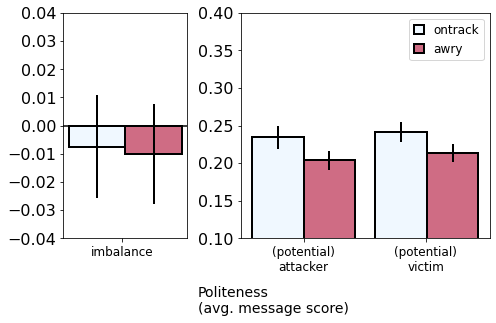

In [56]:
from matplotlib import gridspec
stay_col = "#F0F8FF"
flip_col = "#CF6C84"
lw = 2

fig=plt.figure(figsize=(7, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
#draw the first imbalance bar chart
ax_0 = plt.subplot(gs[0])

width = 0.45

#data = plot_data_1["stay_imba"]
val= ontrack_imb_plt.mean()
err= ontrack_imb_CI_plt[0]
ax_0.bar(0,
            val,
            yerr=err,
            width=width,
            color=stay_col, label='on track',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["flip_imba"]
val= awry_imb_plt.mean()
err= awry_imb_CI_plt[0]
ax_0.bar(width,
            val,
            yerr=err,
            width=width,
            color=flip_col, label='awry',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

plt.xticks([0.2], ["imbalance"], fontsize=12)
#plt.ylabel("imbalance", fontsize=20)
#plt.xlim(-0.05, 0.95)
plt.ylim(-0.04, 0.04)
plt.axhline(0, color='k')

plt.yticks(fontsize=16)



#draw the second imbalance bar chart
ax_1 = plt.subplot(gs[1])

width = 0.5

#data = plot_data_1["stay_btry"]
val= ontrack_attacker_plt.mean()
err= ontrack_attacker_CI_plt[0]
ax_1.bar(0,
            val,
            yerr=err,
            width=width,
            color=stay_col, 
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["flip_btry"]
val= awry_attacker_plt.mean()
err= awry_attacker_CI_plt[0]
ax_1.bar(width,
            val,
            yerr=err,
            width=width,
            color=flip_col, 
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["stay_vctm"]
val= ontrack_victim_plt.mean()
err= ontrack_victim_CI_plt[0]
ax_1.bar(2*width+0.2,
            val,
            yerr=err,
            width=width,
            color=stay_col, label='ontrack',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["flip_vctm"]
val= awry_victim_plt.mean()
err= awry_victim_CI_plt[0]
ax_1.bar(3*width+0.2,
            val,
            yerr=err,
            width=width,
            color=flip_col, label='awry',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))
plt.xticks([0.25,1.44], ['(potential)\nattacker', '(potential)\nvictim'], fontsize=12)
plt.ylim(0.10, 0.40)
plt.axhline(0, color='k')

plt.yticks(fontsize=16)
plt.legend(fontsize=12, loc="upper right", handlelength=0.8)
fig.text(0.4,-0.1, "Politeness\n(avg. message score)",fontsize=14)

plt.tight_layout()
#plt.show()

#### Sentiment

In [57]:
# Add empty column columns
#df = pd.read_csv(inputFile)
#df.head(5)

# header_list_new = ['numSentence', 'numWords', 'totSentiment', 'avgSentiment', 'Sfreq0','Sfreq1','Sfreq2','Sfreq3','Sfreq4','Sfreq5']
# for i, name in enumerate(header_list_new):
#     df[name] = 0

from pycorenlp import StanfordCoreNLP
nlp = StanfordCoreNLP('http://localhost:9000')

# Function; Output = # sentence, # words, avg.sentimentValue, sentimentHist
def stanford_sentiment(text_str):
    res = nlp.annotate(text_str,
                   properties={
                       'annotators': 'sentiment',
                       'outputFormat': 'json',
                       'timeout': 40000,
                   })
    
    numSentence = len(res["sentences"])
    numWords = len(text_str.split())
    
    # data arrangement
    arraySentVal = np.zeros(numSentence)

    for i, s in enumerate(res["sentences"]):
        arraySentVal[i] = int(s["sentimentValue"])

    # sum of sentiment values 
    totSentiment = sum(arraySentVal)

    # avg. of sentiment values 
    avgSentiment = np.mean(arraySentVal)

    # frequency of sentimentValue
    bins = [0,1,2,3,4,5,6]
    freq = np.histogram(arraySentVal, bins)[0]    # getting freq. only w/o bins

    return(numSentence, numWords, totSentiment, avgSentiment, freq)

In [89]:
awry_ids = awry_corpus.get_utterance_ids()

In [ ]:
col_names =  ['u_id', 'numSentence', 'numWords', 'totSentiment', 'avgSentiment']
df = pd.DataFrame(columns=col_names)

print("Total utterance: ", len(awry_ids))
cnt = 0
for uid in awry_ids:
    cnt += 1
    if cnt % 100 == 0:
        print(cnt)
    try:
        numSentence, numWords, totSentiment, avgSentiment, freq = stanford_sentiment(utterances.loc[uid].text)
        df.loc[len(df)] = [uid, numSentence, numWords, totSentiment, avgSentiment]
    except:
        print("error where uid =", uid)
    

outputFile = 'awry_sentiment.csv'
df.to_csv(outputFile, encoding='utf-8', index=False )

In [72]:
stanford_sentiment(utterances.loc['176824876.14917.14917'].text)

Could not handle incoming annotation


In [73]:
utterances.loc['176824876.14917.14917'].text

' Read the citations to the SurveyUSA polls.  They give the exact language, which only specifies those five candidates.  If Ron Paul\'s name was mentioned, he might poll more than they are showing, because people are more inclined to choose one of the available options.\n::::*How does a "minor" candidate become a first-tier candidate if some of the polls don\'t even specify him as an option?  We aren\'t talking about 1-2% any more.  Paul has clearly risen above the "margin of error" argument at this point.  We should question the results of polls that do not even list him as an option, or allow him to be voted for (as the recording I\'ve linked to shows).  At the very least, we should put an asterisk beside polls which do not allow all primary candidates to be voted for.  "Other" is clearly unreasonable as an option. -'

#### Read in sentiments for each utterance

In [58]:
sents = pd.read_csv('awry_sentiment.csv', index_col='u_id')
sents['pctSentiment']=sents['avgSentiment']/sents['totSentiment']
sents

,numSentence,numWords,totSentiment,avgSentiment,pctSentiment
u_id,,,,,
146743638.12652.12652,1,4,2.0,2.000000,1.000000
146743638.12667.12652,3,70,4.0,1.333333,0.333333
146842219.12874.12874,4,86,8.0,2.000000,0.250000
143890867.11926.11926,1,7,2.0,2.000000,1.000000
143890867.11944.11926,4,19,6.0,1.500000,0.250000
...,...,...,...,...,...
98071983.10061.9817,1,6,2.0,2.000000,1.000000
98071983.10077.9817,5,110,8.0,1.600000,0.200000
98073060.10318.10318,18,169,38.0,2.111111,0.055556


In [59]:
df2 = pd.DataFrame(test_utters_df, columns = ['attack','in_bad_convo','conversation_id','speaker'])

In [60]:
df2

,attack,in_bad_convo,conversation_id,speaker
id,,,,
146743638.12652.12652,False,False,146743638.12652.12652,Sirex98
146743638.12667.12652,False,False,146743638.12652.12652,Sirex98
146842219.12874.12874,False,False,146743638.12652.12652,2005
146860774.13072.13072,False,False,146743638.12652.12652,Sirex98
143890867.11926.11926,False,True,143890867.11926.11926,WilyD
...,...,...,...,...
98071983.10061.9817,False,True,98071983.10061.9817,FeloniousMonk
98071983.10077.9817,False,True,98071983.10061.9817,FeloniousMonk
98073060.10318.10318,False,True,98071983.10061.9817,Raspor


In [61]:
feature_df = pd.concat([sents, df2],axis=1)

In [62]:
feature_df

,numSentence,numWords,totSentiment,avgSentiment,pctSentiment,attack,in_bad_convo,conversation_id,speaker
146743638.12652.12652,1.0,4.0,2.0,2.000000,1.000000,False,False,146743638.12652.12652,Sirex98
146743638.12667.12652,3.0,70.0,4.0,1.333333,0.333333,False,False,146743638.12652.12652,Sirex98
146842219.12874.12874,4.0,86.0,8.0,2.000000,0.250000,False,False,146743638.12652.12652,2005
143890867.11926.11926,1.0,7.0,2.0,2.000000,1.000000,False,True,143890867.11926.11926,WilyD
143890867.11944.11926,4.0,19.0,6.0,1.500000,0.250000,False,True,143890867.11926.11926,WilyD
...,...,...,...,...,...,...,...,...,...
194341434.43459.43459,NaN,NaN,NaN,NaN,NaN,True,True,194329616.40576.40576,Montanabw
234747790.16213.16184,NaN,NaN,NaN,NaN,NaN,False,True,234747790.16184.16184,Cdaughertyjr
393326885.19760.19760,NaN,NaN,NaN,NaN,NaN,True,True,393323783.18611.18614,The Founders Intent
73188468.24845.24834,NaN,NaN,NaN,NaN,NaN,False,False,73188468.24834.24834,Geo Swan


### V 2 Sentiment Imbalance and Visualization

In [63]:
# Group by 'conversation_id', 'speaker' and 'in_bad_convo' then get average sentiment score
full_df = feature_df.dropna(axis=0,how='any')
grouped_stmt = full_df['pctSentiment'].astype(float).groupby([full_df['conversation_id'],full_df['speaker'],full_df['in_bad_convo'],full_df['attack']])
means_stmt = pd.DataFrame(grouped_stmt.mean()).unstack()

In [64]:
means_stmt

pctSentiment          
attack                                                   False     True 
conversation_id      speaker         in_bad_convo                       
100009118.8296.8296  Hiding          True             0.166667       NaN
                     Hipocrite       True             0.562500  0.066667
100082597.1198.1198  66.99.2.114     False            0.750000       NaN
                     MKil            False            0.333333       NaN
                     Wompa99         False            1.000000       NaN
...                                                        ...       ...
99357960.32952.32952 Raspor          False            0.777778       NaN
99560738.4755.4755   Captain scarlet True             0.180556       NaN
                     Lewisskinner    True             0.437037  0.166667
99634556.9406.9406   Matthew         False            0.666667       NaN
                     Otto4711        False            0.500000       NaN

[2940 rows x 2 columns]

In [65]:
means_stmt['is_attacker'] = means_stmt['pctSentiment'][True].apply(lambda x: assign_attacker(x))
means_stmt['noattack_positive_sentiment'] = means_stmt['pctSentiment'][False].apply(lambda x: x)

In [66]:
means_stmt['convo_id'] = means_stmt.index.get_level_values(0)

previous_convo=0
means_stmt['is_attacker_assigned'] = means_stmt.loc[:,:,False]['convo_id'].apply(lambda x: each_convo_assign(x))
means_stmt['is_attacker_assigned_full']=means_stmt['is_attacker_assigned'].fillna(means_stmt['is_attacker'])

In [67]:
means_stmt

pctSentiment            \
attack                                                   False      True   
conversation_id      speaker         in_bad_convo                          
100009118.8296.8296  Hiding          True             0.166667       NaN   
                     Hipocrite       True             0.562500  0.066667   
100082597.1198.1198  66.99.2.114     False            0.750000       NaN   
                     MKil            False            0.333333       NaN   
                     Wompa99         False            1.000000       NaN   
...                                                        ...       ...   
99357960.32952.32952 Raspor          False            0.777778       NaN   
99560738.4755.4755   Captain scarlet True             0.180556       NaN   
                     Lewisskinner    True             0.437037  0.166667   
99634556.9406.9406   Matthew         False            0.666667       NaN   
                     Otto4711        False            0.500000       NaN   

                                                  is_attacker  \
attack                                                          
conversation_id      speaker         in_bad_convo               
100009118.8296.8296  Hiding          True               False   
                     Hipocrite       True                True   
100082597.1198.1198  66.99.2.114     False              False   
                     MKil            False              False   
                     Wompa99         False              False   
...                                                       ...   
99357960.32952.32952 Raspor          False              False   
99560738.4755.4755   Captain scarlet True               False   
                     Lewisskinner    True                True   
99634556.9406.9406   Matthew         False              False   
                     Otto4711        False              False   

                                                  noattack_positive_sentiment  \
attack                                                                          
conversation_id      speaker         in_bad_convo                               
100009118.8296.8296  Hiding          True                            0.166667   
                     Hipocrite       True                            0.562500   
100082597.1198.1198  66.99.2.114     False                           0.750000   
                     MKil            False                           0.333333   
                     Wompa99         False                           1.000000   
...                                                                       ...   
99357960.32952.32952 Raspor          False                           0.777778   
99560738.4755.4755   Captain scarlet True                            0.180556   
                     Lewisskinner    True                            0.437037   
99634556.9406.9406   Matthew         False                           0.666667   
                     Otto4711        False                           0.500000   

                                                               convo_id  \
attack                                                                    
conversation_id      speaker         in_bad_convo                         
100009118.8296.8296  Hiding          True           100009118.8296.8296   
                     Hipocrite       True           100009118.8296.8296   
100082597.1198.1198  66.99.2.114     False          100082597.1198.1198   
                     MKil            False          100082597.1198.1198   
                     Wompa99         False          100082597.1198.1198   
...                                                                 ...   
99357960.32952.32952 Raspor          False         99357960.32952.32952   
99560738.4755.4755   Captain scarlet True            99560738.4755.4755   
                     Lewisskinner    True            99560738.4755.4755   
99634556.9406.9406   Matthew         Fa

In [68]:
awry_stmt = means_stmt.loc[:,:,True]['noattack_positive_sentiment'].astype(float).groupby([means_stmt.loc[:,:,True]['convo_id'],means_stmt.loc[:,:,True]['is_attacker_assigned_full']]).mean()
awry_attacker_stmt = awry_stmt[:,True]
awry_victim_stmt = awry_stmt[:,False]
awry_imb_stmt = awry_attacker_stmt - awry_victim_stmt

ontrack_stmt = means_stmt.loc[:,:,False]['noattack_positive_sentiment'].astype(float).groupby([means_stmt.loc[:,:,False]['convo_id'],means_stmt.loc[:,:,False]['is_attacker_assigned_full']]).mean()
ontrack_attacker_stmt = ontrack_stmt[:,True]
ontrack_victim_stmt = ontrack_stmt[:,False]
ontrack_imb_stmt = ontrack_attacker_stmt - ontrack_victim_stmt

ontrack_attacker_CI_stmt = bootstrap_CI_operatevalue(ontrack_attacker_stmt, ontrack_attacker_stmt.mean(), 1000)
ontrack_victim_CI_stmt = bootstrap_CI_operatevalue(ontrack_victim_stmt,ontrack_victim_stmt.mean(), 1000)
ontrack_imb_CI_stmt = bootstrap_CI_operatevalue(ontrack_imb_stmt,ontrack_imb_stmt.mean(), 1000)

awry_attacker_CI_stmt = bootstrap_CI_operatevalue(awry_attacker_stmt, awry_attacker_stmt.mean(), 1000)
awry_victim_CI_stmt = bootstrap_CI_operatevalue(awry_victim_stmt,awry_victim_stmt.mean(), 1000)
awry_imb_CI_stmt = bootstrap_CI_operatevalue(awry_imb_stmt,awry_imb_stmt.mean(), 1000)

In [106]:
#### Draw plotly figures
val_ontrack = ontrack_imb_stmt.mean()
err_ontrack = ontrack_imb_CI_stmt[0]

val_awry = awry_imb_stmt.mean()
err_awry = awry_imb_CI_stmt[0]

fig = go.Figure()
fig.add_trace(go.Bar(
    name='ontrack',
    x=['Sentiment Imbalance'], y=[val_ontrack],
    error_y=dict(type='data', array=[err_ontrack]),
    marker_color="#73dbf0"
))
fig.add_trace(go.Bar(
    name='awry',
    x=['Sentiment Imbalance'], y=[val_awry],
    error_y=dict(type='data', array=[err_awry]),
    marker_color="#f07388"
))
fig.update_layout(barmode='group', title_text='Positive Sentiment (percentage of sentences)')

html = plot(fig, auto_open=False, output_type='div')
with open("E:/EPFL_Courses/ADA/linguistic_datastory/_includes/imbalance_sentiment.html", 'w') as file:
    file.write(html)

In [73]:
stay_col = "#73dbf0"
flip_col = "#f07388"

val_ontrack_attacker = ontrack_attacker_stmt.mean()
err_ontrack_attacker = ontrack_attacker_CI_stmt[0]

val_awry_attacker = awry_attacker_stmt.mean()
err_awry_attacker = awry_attacker_CI_stmt[0]

val_ontrack_victim = ontrack_victim_stmt.mean()
err_ontrack_victim = ontrack_victim_CI_stmt[0]

val_awry_victim = awry_victim_stmt.mean()
err_awry_victim = awry_victim_CI_stmt[0]

fig = go.Figure()
fig.add_trace(go.Bar(
    name='ontrack',
    x=['(potential) attacker', '(potential) victim'], y=[val_ontrack_attacker, val_ontrack_victim],
    error_y=dict(type='data', array=[err_ontrack_attacker, err_ontrack_victim]),
    marker_color="#73dbf0"
))
fig.add_trace(go.Bar(
    name='awry',
    x=['(potential) attacker', '(potential) victim'], y=[val_awry_attacker, val_awry_victim],
    error_y=dict(type='data', array=[err_awry_attacker, err_awry_victim]),
    marker_color="#f07388"
))

fig.update_layout(barmode='group', title_text='Positive Sentiment (percentage of sentences)')

html = plot(fig, auto_open=False, output_type='div')
with open("E:/EPFL_Courses/ADA/linguistic_datastory/_includes/imbalance_sentiment_2.html", 'w') as file:
    file.write(html)

In [116]:
### combine them together
fig = make_subplots(rows=1, cols=2, column_widths=[0.3, 0.7])

val_ontrack = ontrack_imb_stmt.mean()
err_ontrack = ontrack_imb_CI_stmt[0]

val_awry = awry_imb_stmt.mean()
err_awry = awry_imb_CI_stmt[0]

fig.add_trace(go.Bar(
    name='ontrack',
    x=['Sentiment Imbalance'], y=[val_ontrack],
    error_y=dict(type='data', array=[err_ontrack]),
    marker_color="#f8921d"),
    row=1, col=1)
fig.add_trace(go.Bar(
    name='awry',
    x=['Sentiment Imbalance'], y=[val_awry],
    error_y=dict(type='data', array=[err_awry]),
    marker_color="#FFFC99"),
    row=1, col=1)


stay_col = "#73dbf0"
flip_col = "#f07388"

val_ontrack_attacker = ontrack_attacker_stmt.mean()
err_ontrack_attacker = ontrack_attacker_CI_stmt[0]

val_awry_attacker = awry_attacker_stmt.mean()
err_awry_attacker = awry_attacker_CI_stmt[0]

val_ontrack_victim = ontrack_victim_stmt.mean()
err_ontrack_victim = ontrack_victim_CI_stmt[0]

val_awry_victim = awry_victim_stmt.mean()
err_awry_victim = awry_victim_CI_stmt[0]

fig.add_trace(go.Bar(
    name='ontrack',
    x=['(potential) attacker', '(potential) victim'], y=[val_ontrack_attacker, val_ontrack_victim],
    error_y=dict(type='data', array=[err_ontrack_attacker, err_ontrack_victim]),
    marker_color="#f8921d"),
    row=1, col=2)
fig.add_trace(go.Bar(
    name='awry',
    x=['(potential) attacker', '(potential) victim'], y=[val_awry_attacker, val_awry_victim],
    error_y=dict(type='data', array=[err_awry_attacker, err_awry_victim]),
    marker_color="#FFFC99"),
    row=1, col=2)

fig.update_layout(barmode='group', title_text='Positive Sentiment (percentage of sentences)')

html = plot(fig, auto_open=False, output_type='div')
with open("E:/EPFL_Courses/ADA/linguistic_datastory/_includes/imbalance_sentiment_combine.html", 'w') as file:
    file.write(html)

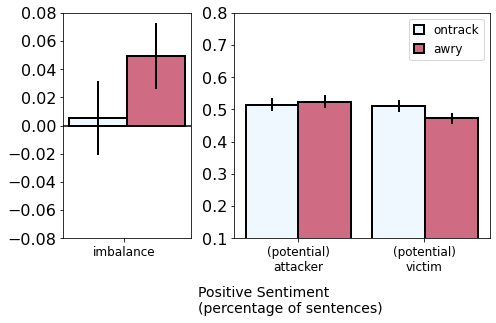

In [69]:
from matplotlib import gridspec
stay_col = "#F0F8FF"
flip_col = "#CF6C84"
lw = 2

fig=plt.figure(figsize=(7, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
#draw the first imbalance bar chart
ax_0 = plt.subplot(gs[0])

width = 0.45

#data = plot_data_1["stay_imba"]
val= ontrack_imb_stmt.mean()
err= ontrack_imb_CI_stmt[0]
ax_0.bar(0,
            val,
            yerr=err,
            width=width,
            color=stay_col, label='on track',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["flip_imba"]
val= awry_imb_stmt.mean()
err= awry_imb_CI_stmt[0]
ax_0.bar(width,
            val,
            yerr=err,
            width=width,
            color=flip_col, label='awry',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

plt.xticks([0.2], ["imbalance"], fontsize=12)
#plt.ylabel("imbalance", fontsize=20)
#plt.xlim(-0.05, 0.95)
plt.ylim(-0.08, 0.08)
plt.axhline(0, color='k')

plt.yticks(fontsize=16)


#draw the second imbalance bar chart
ax_1 = plt.subplot(gs[1])

width = 0.5

#data = plot_data_1["stay_btry"]
val= ontrack_attacker_stmt.mean()
err= ontrack_attacker_CI_stmt[0]
ax_1.bar(0,
            val,
            yerr=err,
            width=width,
            color=stay_col, 
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["flip_btry"]
val= awry_attacker_stmt.mean()
err= awry_attacker_CI_stmt[0]
ax_1.bar(width,
            val,
            yerr=err,
            width=width,
            color=flip_col, 
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["stay_vctm"]
val= ontrack_victim_stmt.mean()
err= ontrack_victim_CI_stmt[0]
ax_1.bar(2*width+0.2,
            val,
            yerr=err,
            width=width,
            color=stay_col, label='ontrack',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["flip_vctm"]
val= awry_victim_stmt.mean()
err= awry_victim_CI_stmt[0]
ax_1.bar(3*width+0.2,
            val,
            yerr=err,
            width=width,
            color=flip_col, label='awry',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))
plt.xticks([0.25,1.44], ['(potential)\nattacker', '(potential)\nvictim'], fontsize=12)
plt.ylim(0.10, 0.80)
plt.axhline(0, color='k')

plt.yticks(fontsize=16)
plt.legend(fontsize=12, loc="upper right", handlelength=0.8)
fig.text(0.4,-0.1, "Positive Sentiment\n(percentage of sentences)",fontsize=14)

plt.tight_layout()
plt.show()

### V 3 Talktiveness Imbalance and Visualization

In [70]:
full_df

,numSentence,numWords,totSentiment,avgSentiment,pctSentiment,attack,in_bad_convo,conversation_id,speaker
146743638.12652.12652,1.0,4.0,2.0,2.000000,1.000000,False,False,146743638.12652.12652,Sirex98
146743638.12667.12652,3.0,70.0,4.0,1.333333,0.333333,False,False,146743638.12652.12652,Sirex98
146842219.12874.12874,4.0,86.0,8.0,2.000000,0.250000,False,False,146743638.12652.12652,2005
143890867.11926.11926,1.0,7.0,2.0,2.000000,1.000000,False,True,143890867.11926.11926,WilyD
143890867.11944.11926,4.0,19.0,6.0,1.500000,0.250000,False,True,143890867.11926.11926,WilyD
...,...,...,...,...,...,...,...,...,...
98071983.10061.9817,1.0,6.0,2.0,2.000000,1.000000,False,True,98071983.10061.9817,FeloniousMonk
98071983.10077.9817,5.0,110.0,8.0,1.600000,0.200000,False,True,98071983.10061.9817,FeloniousMonk
98073060.10318.10318,18.0,169.0,38.0,2.111111,0.055556,False,True,98071983.10061.9817,Raspor
98075017.10675.10675,4.0,56.0,8.0,2.000000,0.250000,False,True,98071983.10061.9817,Ec5618


In [71]:
grouped_tlk = full_df['numWords'].astype(float).groupby([full_df['conversation_id'],full_df['speaker'],full_df['in_bad_convo'],full_df['attack']])
means_tlk = pd.DataFrame(grouped_tlk.mean()).unstack()

In [72]:
means_tlk['is_attacker'] = means_tlk['numWords'][True].apply(lambda x: assign_attacker(x))
means_tlk['noattack_numWords'] = means_tlk['numWords'][False].apply(lambda x: x)

In [73]:
means_tlk['convo_id'] = means_tlk.index.get_level_values(0)

previous_convo=0
means_tlk['is_attacker_assigned'] = means_tlk.loc[:,:,False]['convo_id'].apply(lambda x: each_convo_assign(x))
means_tlk['is_attacker_assigned_full']=means_tlk['is_attacker_assigned'].fillna(means_tlk['is_attacker'])

In [74]:
awry_tlk = means_tlk.loc[:,:,True]['noattack_numWords'].astype(float).groupby([means_tlk.loc[:,:,True]['convo_id'],means_tlk.loc[:,:,True]['is_attacker_assigned_full']]).mean()
awry_attacker_tlk = awry_tlk[:,True]
awry_victim_tlk = awry_tlk[:,False]
awry_imb_tlk = awry_attacker_tlk - awry_victim_tlk

ontrack_tlk = means_tlk.loc[:,:,False]['noattack_numWords'].astype(float).groupby([means_tlk.loc[:,:,False]['convo_id'],means_tlk.loc[:,:,False]['is_attacker_assigned_full']]).mean()
ontrack_attacker_tlk = ontrack_tlk[:,True]
ontrack_victim_tlk = ontrack_tlk[:,False]
ontrack_imb_tlk = ontrack_attacker_tlk - ontrack_victim_tlk

ontrack_attacker_CI_tlk = bootstrap_CI_operatevalue(ontrack_attacker_tlk, ontrack_attacker_tlk.mean(), 1000)
ontrack_victim_CI_tlk = bootstrap_CI_operatevalue(ontrack_victim_tlk,ontrack_victim_tlk.mean(), 1000)
ontrack_imb_CI_tlk = bootstrap_CI_operatevalue(ontrack_imb_tlk,ontrack_imb_tlk.mean(), 1000)

awry_attacker_CI_tlk = bootstrap_CI_operatevalue(awry_attacker_tlk, awry_attacker_tlk.mean(), 1000)
awry_victim_CI_tlk = bootstrap_CI_operatevalue(awry_victim_tlk,awry_victim_tlk.mean(), 1000)
awry_imb_CI_tlk = bootstrap_CI_operatevalue(awry_imb_tlk,awry_imb_tlk.mean(), 1000)

In [75]:
#### Draw plotly figures
val_ontrack = ontrack_imb_tlk.mean()
err_ontrack = ontrack_imb_CI_tlk[0]

val_awry = awry_imb_tlk.mean()
err_awry = awry_imb_CI_tlk[0]

fig = go.Figure()
fig.add_trace(go.Bar(
    name='ontrack',
    x=['Talktiveness Imbalance'], y=[val_ontrack],
    error_y=dict(type='data', array=[err_ontrack]),
    marker_color="#73dbf0"
))
fig.add_trace(go.Bar(
    name='awry',
    x=['Talktiveness Imbalance'], y=[val_awry],
    error_y=dict(type='data', array=[err_awry]),
    marker_color="#f07388"
))
fig.update_layout(barmode='group', title_text='Talkativeness (number of words)')

html = plot(fig, auto_open=False, output_type='div')
with open("E:/EPFL_Courses/ADA/linguistic_datastory/_includes/imbalance_talktiveness.html", 'w') as file:
    file.write(html)

In [76]:
stay_col = "#73dbf0"
flip_col = "#f07388"

val_ontrack_attacker = ontrack_attacker_tlk.mean()
err_ontrack_attacker = ontrack_attacker_CI_tlk[0]

val_awry_attacker = awry_attacker_tlk.mean()
err_awry_attacker = awry_attacker_CI_tlk[0]

val_ontrack_victim = ontrack_victim_tlk.mean()
err_ontrack_victim = ontrack_victim_CI_tlk[0]

val_awry_victim = awry_victim_tlk.mean()
err_awry_victim = awry_victim_CI_tlk[0]

fig = go.Figure()
fig.add_trace(go.Bar(
    name='ontrack',
    x=['(potential) attacker', '(potential) victim'], y=[val_ontrack_attacker, val_ontrack_victim],
    error_y=dict(type='data', array=[err_ontrack_attacker, err_ontrack_victim]),
    marker_color="#73dbf0"
))
fig.add_trace(go.Bar(
    name='awry',
    x=['(potential) attacker', '(potential) victim'], y=[val_awry_attacker, val_awry_victim],
    error_y=dict(type='data', array=[err_awry_attacker, err_awry_victim]),
    marker_color="#f07388"
))

fig.update_layout(barmode='group', title_text='Talkativeness (number of words)')

html = plot(fig, auto_open=False, output_type='div')
with open("E:/EPFL_Courses/ADA/linguistic_datastory/_includes/imbalance_talktiveness_2.html", 'w') as file:
    file.write(html)

In [117]:
#### combine them together
fig = make_subplots(rows=1, cols=2, column_widths=[0.3, 0.7])


val_ontrack = ontrack_imb_tlk.mean()
err_ontrack = ontrack_imb_CI_tlk[0]

val_awry = awry_imb_tlk.mean()
err_awry = awry_imb_CI_tlk[0]

fig.add_trace(go.Bar(
    name='ontrack',
    x=['Talktiveness Imbalance'], y=[val_ontrack],
    error_y=dict(type='data', array=[err_ontrack]),
    marker_color="#FFE882"),
    row=1, col=1)
fig.add_trace(go.Bar(
    name='awry',
    x=['Talktiveness Imbalance'], y=[val_awry],
    error_y=dict(type='data', array=[err_awry]),
    marker_color="#554840"),
    row=1, col=1)

stay_col = "#73dbf0"
flip_col = "#f07388"

val_ontrack_attacker = ontrack_attacker_tlk.mean()
err_ontrack_attacker = ontrack_attacker_CI_tlk[0]

val_awry_attacker = awry_attacker_tlk.mean()
err_awry_attacker = awry_attacker_CI_tlk[0]

val_ontrack_victim = ontrack_victim_tlk.mean()
err_ontrack_victim = ontrack_victim_CI_tlk[0]

val_awry_victim = awry_victim_tlk.mean()
err_awry_victim = awry_victim_CI_tlk[0]

fig.add_trace(go.Bar(
    name='ontrack',
    x=['(potential) attacker', '(potential) victim'], y=[val_ontrack_attacker, val_ontrack_victim],
    error_y=dict(type='data', array=[err_ontrack_attacker, err_ontrack_victim]),
    marker_color="#FFE882"),
    row=1, col=2)
fig.add_trace(go.Bar(
    name='awry',
    x=['(potential) attacker', '(potential) victim'], y=[val_awry_attacker, val_awry_victim],
    error_y=dict(type='data', array=[err_awry_attacker, err_awry_victim]),
    marker_color="#554840"),
    row=1, col=2)

fig.update_layout(barmode='group', title_text='Talkativeness (number of words)')

html = plot(fig, auto_open=False, output_type='div')
with open("E:/EPFL_Courses/ADA/linguistic_datastory/_includes/imbalance_talktiveness_combine.html", 'w') as file:
    file.write(html)

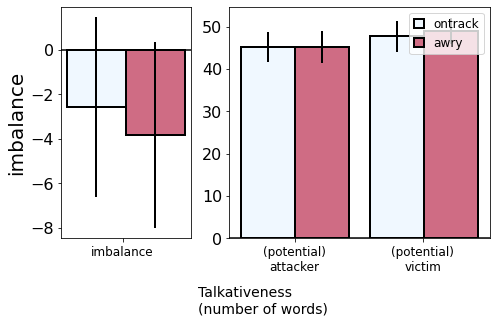

In [78]:
stay_col = "#F0F8FF"
flip_col = "#CF6C84"
lw = 2

fig=plt.figure(figsize=(7, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
#draw the first imbalance bar chart
ax_0 = plt.subplot(gs[0])

width = 0.45

#data = plot_data_1["stay_imba"]
val= ontrack_imb_tlk.mean()
err= ontrack_imb_CI_tlk[0]
ax_0.bar(0,
            val,
            yerr=err,
            width=width,
            color=stay_col, label='on track',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["flip_imba"]
val= awry_imb_tlk.mean()
err= awry_imb_CI_tlk[0]
ax_0.bar(width,
            val,
            yerr=err,
            width=width,
            color=flip_col, label='awry',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

plt.xticks([0.2], ["imbalance"], fontsize=12)
plt.ylabel("imbalance", fontsize=20)
#plt.xlim(-0.05, 0.95)
#plt.ylim(-0.5, 0.5)
plt.axhline(0, color='k')

plt.yticks(fontsize=16)


#draw the second imbalance bar chart
ax_1 = plt.subplot(gs[1])

width = 0.5

#data = plot_data_1["stay_btry"]
val= ontrack_attacker_tlk.mean()
err= ontrack_attacker_CI_tlk[0]
ax_1.bar(0,
            val,
            yerr=err,
            width=width,
            color=stay_col, 
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["flip_btry"]
val= awry_attacker_tlk.mean()
err= awry_attacker_CI_tlk[0]
ax_1.bar(width,
            val,
            yerr=err,
            width=width,
            color=flip_col, 
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["stay_vctm"]
val= ontrack_victim_tlk.mean()
err= ontrack_victim_CI_tlk[0]
ax_1.bar(2*width+0.2,
            val,
            yerr=err,
            width=width,
            color=stay_col, label='ontrack',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))

#data = plot_data_1["flip_vctm"]
val= awry_victim_tlk.mean()
err= awry_victim_CI_tlk[0]
ax_1.bar(3*width+0.2,
            val,
            yerr=err,
            width=width,
            color=flip_col, label='awry',
            edgecolor='black',
            linewidth=lw,
            error_kw=dict(elinewidth=2, capthick=2, ecolor='k'))
plt.xticks([0.25,1.44], ['(potential)\nattacker', '(potential)\nvictim'], fontsize=12)
#plt.ylim(0.10, 0.80)
plt.axhline(0, color='k')

plt.yticks(fontsize=16)
plt.legend(fontsize=12, loc="upper right", handlelength=0.8)
fig.text(0.4,-0.1, "Talkativeness\n(number of words)",fontsize=14)

plt.tight_layout()
plt.show()

### Prediction

In [85]:
# select the politeness score in the first and second utterance of each conversation

data_pol = pd.read_csv('pred_politeness.xls')
data_pol.columns=['pre_polite_1','pre_polite_2','attack_p']
data_pol['attack_p']=data_pol['attack_p'].astype(int)
data_pol = data_pol.rename_axis("Num_con")
data_pol

,pre_polite_1,pre_polite_2,attack_p
Num_con,,,
0,0.295689,0.737203,1
1,0.234452,0.106919,0
2,0.962891,0.083359,1
3,0.917265,0.189851,0
4,0.126228,0.132515,1
...,...,...,...
1163,0.125389,0.148742,1
1164,0.350113,0.188946,1
1165,0.083359,0.067104,0


In [89]:
# select the sentiment score in the first and second utterance of each conversation

data_sen = pd.read_csv('pred_sentiment.xls')
data_sen.columns=['score_sen_1','score_sen_2','attack_s']
data_sen['attack_s']=data_sen['attack_s'].astype(int)
data_sen = data_sen.rename_axis("Num_con")
data_sen

,score_sen_1,score_sen_2,attack_s
Num_con,,,
0,0.125000,0.166667,1
1,1.000000,0.500000,0
2,0.083333,1.000000,1
3,0.200000,0.200000,0
4,1.000000,0.125000,1
...,...,...,...
1163,0.200000,0.055556,1
1164,0.250000,0.166667,1
1165,1.000000,0.333333,0


In [90]:
# select the number of sentence in the first and second utterance of each conversation

data_tal = pd.read_csv('pred_talkativeness.xls')
data_tal.columns=['numword_1','numword_2','attack_t']
data_tal['attack_t']=data_tal['attack_t'].astype(int)
data_tal = data_tal.rename_axis("Num_con")
data_tal

,numword_1,numword_2,attack_t
Num_con,,,
0,122.0,137.0,1
1,17.0,36.0,0
2,122.0,4.0,1
3,44.0,129.0,0
4,4.0,163.0,1
...,...,...,...
1163,110.0,169.0,1
1164,91.0,144.0,1
1165,6.0,37.0,0


In [91]:
# merge the politeness score, sentiment score and number of sentence in each conversation

data_uni = pd.concat([data_pol,data_sen,data_tal],axis=1)
data_uni = data_uni.drop(['attack_p','attack_s'],axis=1)
data_uni = data_uni.rename(columns={'attack_t':'attack'})
data_uni

,pre_polite_1,pre_polite_2,score_sen_1,score_sen_2,numword_1,numword_2,attack
Num_con,,,,,,,
0,0.295689,0.737203,0.125000,0.166667,122.0,137.0,1
1,0.234452,0.106919,1.000000,0.500000,17.0,36.0,0
2,0.962891,0.083359,0.083333,1.000000,122.0,4.0,1
3,0.917265,0.189851,0.200000,0.200000,44.0,129.0,0
4,0.126228,0.132515,1.000000,0.125000,4.0,163.0,1
...,...,...,...,...,...,...,...
1163,0.125389,0.148742,0.200000,0.055556,110.0,169.0,1
1164,0.350113,0.188946,0.250000,0.166667,91.0,144.0,1
1165,0.083359,0.067104,1.000000,0.333333,6.0,37.0,0


#### 1. Politeness

In [92]:
# perform a regression analysis to model the conversation attack sign, among the politeness scores.

from statsmodels.formula.api import logit
data_log_p = logit(formula='attack_p ~ pre_polite_1+pre_polite_2', data=data_pol).fit()
print(data_log_p.summary())

Optimization terminated successfully.
         Current function value: 0.691273
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               attack_p   No. Observations:                 1168
Model:                          Logit   Df Residuals:                     1165
Method:                           MLE   Df Model:                            2
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                0.002704
Time:                        22:39:52   Log-Likelihood:                -807.41
converged:                       True   LL-Null:                       -809.60
Covariance Type:            nonrobust   LLR p-value:                    0.1120
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1640      0.099      1.663      0.096      -0.029       0.357
pre_polite_1    -0.3481

This model lets us see that the politeness score is associated with the attack action.

In [93]:
# transform the politeness score and the attack sign into array respectively

X_p = data_pol[['pre_polite_1','pre_polite_2']]
y_p = np.array(data_pol['attack_p'])
X_p.shape, y_p.shape

((1168, 2), (1168,))

In [96]:
# perform the cross-validation model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(solver='liblinear', random_state=0)

In [97]:
scores_p = cross_val_score(clf, X_p, y_p, cv=5)
scores_p

array([0.57692308, 0.4957265 , 0.50854701, 0.53648069, 0.54506438])

In [98]:
# To obtain 95% bootstrapped confidence intervals around the estimated average 

def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)
        
    dis = np.nanpercentile(means, 97.5)-np.nanpercentile(means, 2.5)
    CI = dis.astype(float)

    return CI

In [99]:
# print the across-validation accuracy with 95% bootstrapped confidence interval

print("Accuracy of politeness: %0.2f%% (+/- %0.3f)" % (np.mean(scores_p)*100, bootstrap_CI(scores_p, 1000)))

Accuracy of politeness: 53.25% (+/- 0.047)


#### 2. Sentiment

In [100]:
# perform a regression analysis to model the conversation attack sign, among the sentiment scores.

data_log_s = logit(formula='attack_s ~ score_sen_1+score_sen_2', data=data_sen).fit()
print(data_log_s.summary())

Optimization terminated successfully.
         Current function value: 0.691150
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               attack_s   No. Observations:                 1168
Model:                          Logit   Df Residuals:                     1165
Method:                           MLE   Df Model:                            2
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                0.002882
Time:                        22:42:06   Log-Likelihood:                -807.26
converged:                       True   LL-Null:                       -809.60
Covariance Type:            nonrobust   LLR p-value:                   0.09700
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1045      0.133      0.784      0.433      -0.157       0.366
score_sen_1     0.2135    

This model lets us see that the sentiment score is associated with the attack action.

In [101]:
# transform the sentiment score and the attack sign into array respectively

X_s = data_sen[['score_sen_1','score_sen_2']]
y_s = np.array(data_sen['attack_s'])
X_s.shape, y_s.shape

((1168, 2), (1168,))

In [102]:
# perform the cross-validation model

scores_s = cross_val_score(clf, X_s, y_s, cv=5)
scores_s

array([0.52564103, 0.48290598, 0.48717949, 0.53218884, 0.55364807])

In [103]:
# print the across-validation accuracy with 95% bootstrapped confidence interval

print("Accuracy of sensitiveness: %0.2f%% (+/- %0.3f)" % (np.mean(scores_s)*100, bootstrap_CI(scores_s, 1000)))

Accuracy of sensitiveness: 51.63% (+/- 0.048)


#### 3. Talkativeness

In [104]:
# perform a regression analysis to model the conversation attack sign, among the number of sentence in each conversation.

data_log_t = logit(formula='attack_t ~ numword_1+numword_2', data=data_tal).fit()
print(data_log_s.summary())

Optimization terminated successfully.
         Current function value: 0.692528
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               attack_s   No. Observations:                 1168
Model:                          Logit   Df Residuals:                     1165
Method:                           MLE   Df Model:                            2
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                0.002882
Time:                        22:43:00   Log-Likelihood:                -807.26
converged:                       True   LL-Null:                       -809.60
Covariance Type:            nonrobust   LLR p-value:                   0.09700
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1045      0.133      0.784      0.433      -0.157       0.366
score_sen_1     0.2135    

This model lets us see that the number of sentence is associated with the attack action.

In [107]:
# transform the number of sentence and the attack sign into array respectively

X_t = data_tal[['numword_1','numword_2']]
y_t = np.array(data_tal['attack_t'])
X_t.shape, y_t.shape

((1168, 2), (1168,))

In [109]:
# perform the cross-validation model

scores_t = cross_val_score(clf, X_t, y_t, cv=5)
scores_t

array([0.52991453, 0.46153846, 0.51282051, 0.5193133 , 0.50643777])

In [110]:
# print the across-validation accuracy with 95% bootstrapped confidence interval

print("Accuracy of talkativeness: %0.2f%% (+/- %0.3f)" % (np.mean(scores_t)*100, bootstrap_CI(scores_t, 1000)))

Accuracy of talkativeness: 50.60% (+/- 0.040)


#### 4. Integrated features

In [111]:
# perform a regression analysis to model the conversation attack sign, among the integrated features.

data_log_u = logit(formula='attack ~ pre_polite_1+pre_polite_2+score_sen_1+score_sen_2+numword_1+numword_2', data=data_uni).fit()
print(data_log_u.summary())

Optimization terminated successfully.
         Current function value: 0.687183
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 attack   No. Observations:                 1168
Model:                          Logit   Df Residuals:                     1161
Method:                           MLE   Df Model:                            6
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                0.008604
Time:                        22:45:49   Log-Likelihood:                -802.63
converged:                       True   LL-Null:                       -809.60
Covariance Type:            nonrobust   LLR p-value:                   0.03041
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7499      0.267      2.805      0.005       0.226       1.274
pre_polite_1    -0.3254

In [112]:
# transform the integrated features and the attack sign into array respectively

X_u = data_uni[['pre_polite_1','pre_polite_2','score_sen_1','score_sen_2','numword_1','numword_2']]
y_u = np.array(data_uni['attack'])
X_u.shape, y_u.shape

((1168, 6), (1168,))

In [113]:
# perform the cross-validation model

scores_u = cross_val_score(clf, X_u, y_u, cv=5)
scores_u

array([0.53846154, 0.50854701, 0.4957265 , 0.55364807, 0.54077253])

In [114]:
# print the across-validation accuracy with 95% bootstrapped confidence interval

print("Accuracy of politeness: %0.2f%% (+/- %0.3f)" % (np.mean(scores_p)*100, bootstrap_CI(scores_p, 1000)))
print("Accuracy of sensitiveness: %0.2f%% (+/- %0.3f)" % (np.mean(scores_s)*100, bootstrap_CI(scores_s, 1000)))
print("Accuracy of talkativeness: %0.2f%% (+/- %0.3f)" % (np.mean(scores_t)*100, bootstrap_CI(scores_t, 1000)))
print("Accuracy across all selected features: %0.2f%% (+/- %0.3f)" % (np.mean(scores_u)*100, bootstrap_CI(scores_u, 1000)))

Accuracy of politeness: 53.25% (+/- 0.047)
Accuracy of sensitiveness: 51.63% (+/- 0.046)
Accuracy of talkativeness: 50.60% (+/- 0.040)
Accuracy across all selected features: 52.74% (+/- 0.036)


### Finished